# Property Prediction with Machine Learning

Machine learning, particularly deep learning, has recently made significant advancements in bottom-up mass spectrometry proteomics. One of its most impactful applications is the prediction of various peptide or ion properties. Key prediction tasks include:

* Retention time prediction
* Ion mobility prediction
* Fragment ion intensity prediction

With the increasing availability of models and frameworks, Python has become the go-to interface, thanks to its robust ecosystem of machine learning libraries such as TensorFlow, PyTorch, and JAX.

This notebook provides a hands-on example using the `imspy` library to predict peptide and ion properties. `imspy` utilizes a [Prosit model](https://www.nature.com/articles/s41467-024-48322-0), which is optimized for timsTOF data, to predict fragment ion intensity.

You can easily adapt this notebook for non-timsTOF datasets by replacing the first cell with your own data import and creating PSMs using the `sagepy` library.

In this tutorial, you will:

* Read an ion-mobility DDA dataset
* Perform retention time, ion mobility, and fragment intensity prediction
* Serialize to disk

## Read raw data
Start by downloading the data from [JPOST](https://repository.jpostdb.org/entry/JPST002158), e.g., the dataset `M210115_001_Slot1-1_1_850.d.rar` and unpack it into a directory of your choice.

In [5]:
from imspy.timstof import extract_timstof_dda_data

# This function will extract raw timsTOF dda data and generate a ready-to-score dataset from it, data read in can take a minute or two
# CAUTION: Currently, MAC-OS is not supported by bruker binaries, so this might fail if you are on MAC
raw_data = extract_timstof_dda_data(
    path="/path/to/file/M210115_001_Slot1-1_1_850.d",
    in_memory=False
)

## Generate initial PSMs

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sagepy.utility import create_sage_database

fasta_path = "/path/to/proteome.fasta"

static_mods = {"C": "[UNIMOD:4]"}
variable_mods = {"M": ["[UNIMOD:1]", "[UNIMOD:35]"], "[M": ["[UNIMOD:1]"]}

indexed_database = create_sage_database(
    fasta_path = fasta_path,
    static_mods = static_mods,
    variable_mods = variable_mods,
    min_len=8,
    # Prosit can handle sequences up to a length of 30, so we set this as the max number of AAs
    max_len=30,
)

In [7]:
from sagepy.core import Scorer

# create a scorer
scorer = Scorer(report_psms=5, min_matched_peaks=5, static_mods=static_mods, variable_mods=variable_mods)

# generate a collection of psms
psms = scorer.score_collection_psm(
    db=indexed_database, 
    spectrum_collection=raw_data.processed_spec.values,
    num_threads=16,
)

In [8]:
# the prediction modules all expect list of psms, so we flatten the returned dict into a list
psm_list = []

for psm_id, matches in psms.items():
    psm_list.extend(matches)

In [10]:
from imspy.algorithm import predict_retention_time
predict_retention_time(psm_collection=psm_list, refine_model=True, verbose=True)

Epoch 1/150
243/243 [==============================] - 9s 18ms/step - loss: 2.0862 - val_loss: 4.6663 - lr: 0.0010
Epoch 2/150
243/243 [==============================] - 3s 14ms/step - loss: 1.8679 - val_loss: 4.6476 - lr: 0.0010
Epoch 3/150
243/243 [==============================] - 3s 14ms/step - loss: 1.7742 - val_loss: 4.3534 - lr: 0.0010
Epoch 4/150
243/243 [==============================] - 3s 14ms/step - loss: 1.7070 - val_loss: 4.7960 - lr: 0.0010
Epoch 5/150
243/243 [==============================] - 3s 14ms/step - loss: 1.6636 - val_loss: 4.9724 - lr: 0.0010
Epoch 6/150
243/243 [==============================] - 3s 14ms/step - loss: 1.5579 - val_loss: 4.7452 - lr: 0.0010
Epoch 7/150
243/243 [==============================] - 3s 14ms/step - loss: 1.4241 - val_loss: 4.5762 - lr: 1.0000e-04
Epoch 8/150
243/243 [==============================] - 3s 14ms/step - loss: 1.4214 - val_loss: 4.5738 - lr: 1.0000e-04
Epoch 9/150
86/86 [==============================] - 2s 13ms/step


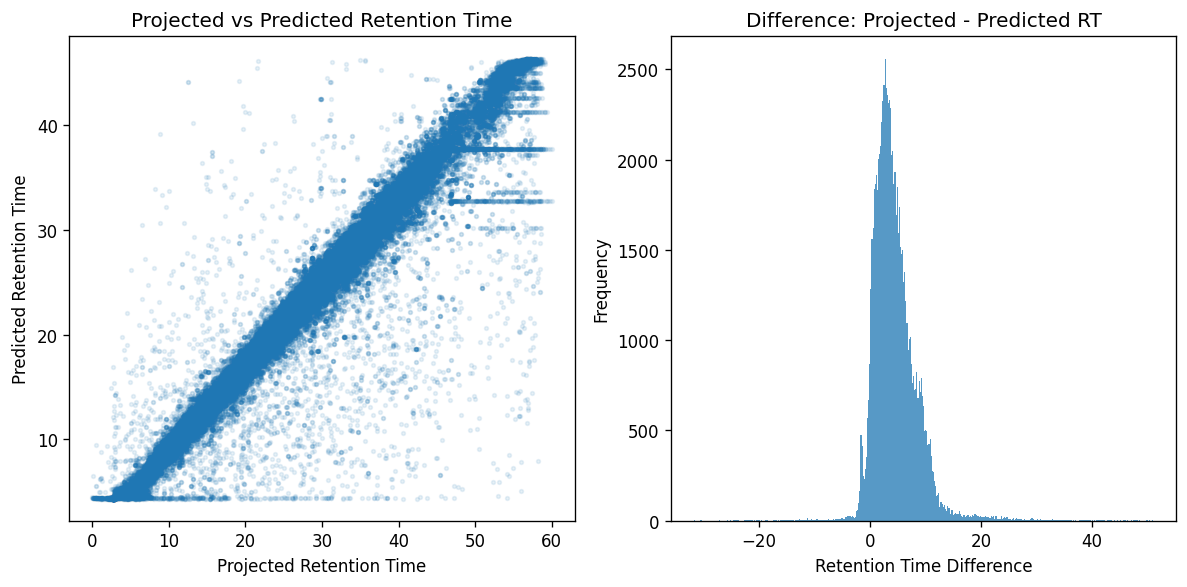

In [11]:
projected_rt = [x.projected_rt for x in psm_list]
retention_time_predicted = [x.retention_time_predicted for x in psm_list]
rt_difference = [x.projected_rt - x.retention_time_predicted for x in psm_list]

# Create a figure with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=120)

ax1.scatter(projected_rt, retention_time_predicted, alpha=0.1, s=5)
ax1.set_title("Projected vs Predicted Retention Time")
ax1.set_xlabel("Projected Retention Time")
ax1.set_ylabel("Predicted Retention Time")

ax2.hist(rt_difference, bins="auto", alpha=0.75)
ax2.set_title("Difference: Projected - Predicted RT")
ax2.set_xlabel("Retention Time Difference")
ax2.set_ylabel("Frequency")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [12]:
from imspy.algorithm import predict_inverse_ion_mobility
predict_inverse_ion_mobility(psm_collection=psm_list, refine_model=True, verbose=False)

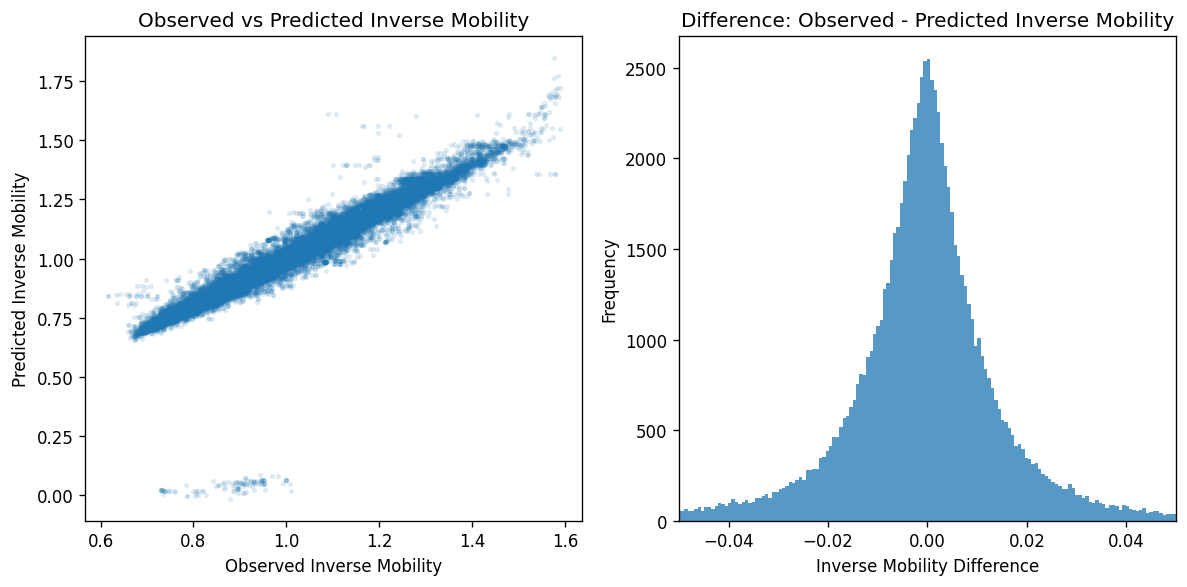

In [13]:
inverse_mobility_observed = [x.inverse_mobility_observed for x in psm_list]
inverse_mobility_predicted = [x.inverse_mobility_predicted for x in psm_list]
mobility_difference = [x.inverse_mobility_observed - x.inverse_mobility_predicted for x in psm_list]

# Create a figure with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=120)

ax1.scatter(inverse_mobility_observed, inverse_mobility_predicted, alpha=0.1, s=5)
ax1.set_title("Observed vs Predicted Inverse Mobility")
ax1.set_xlabel("Observed Inverse Mobility")
ax1.set_ylabel("Predicted Inverse Mobility")

ax2.hist(mobility_difference, bins="auto", alpha=0.75)
ax2.set_title("Difference: Observed - Predicted Inverse Mobility")
ax2.set_xlabel("Inverse Mobility Difference")
ax2.set_ylabel("Frequency")
ax2.set_xlim([-0.05, 0.05])

plt.tight_layout()
plt.show()

In [14]:
from imspy.algorithm import predict_intensities_prosit

# this will add predicted intensities to every PSM and also add the cosine similarity between predicted and observed spectra
predict_intensities_prosit(psm_collection=psm_list)

/home/administrator/Documents/promotion/ENV-11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/administrator/Documents/promotion/ENV-11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


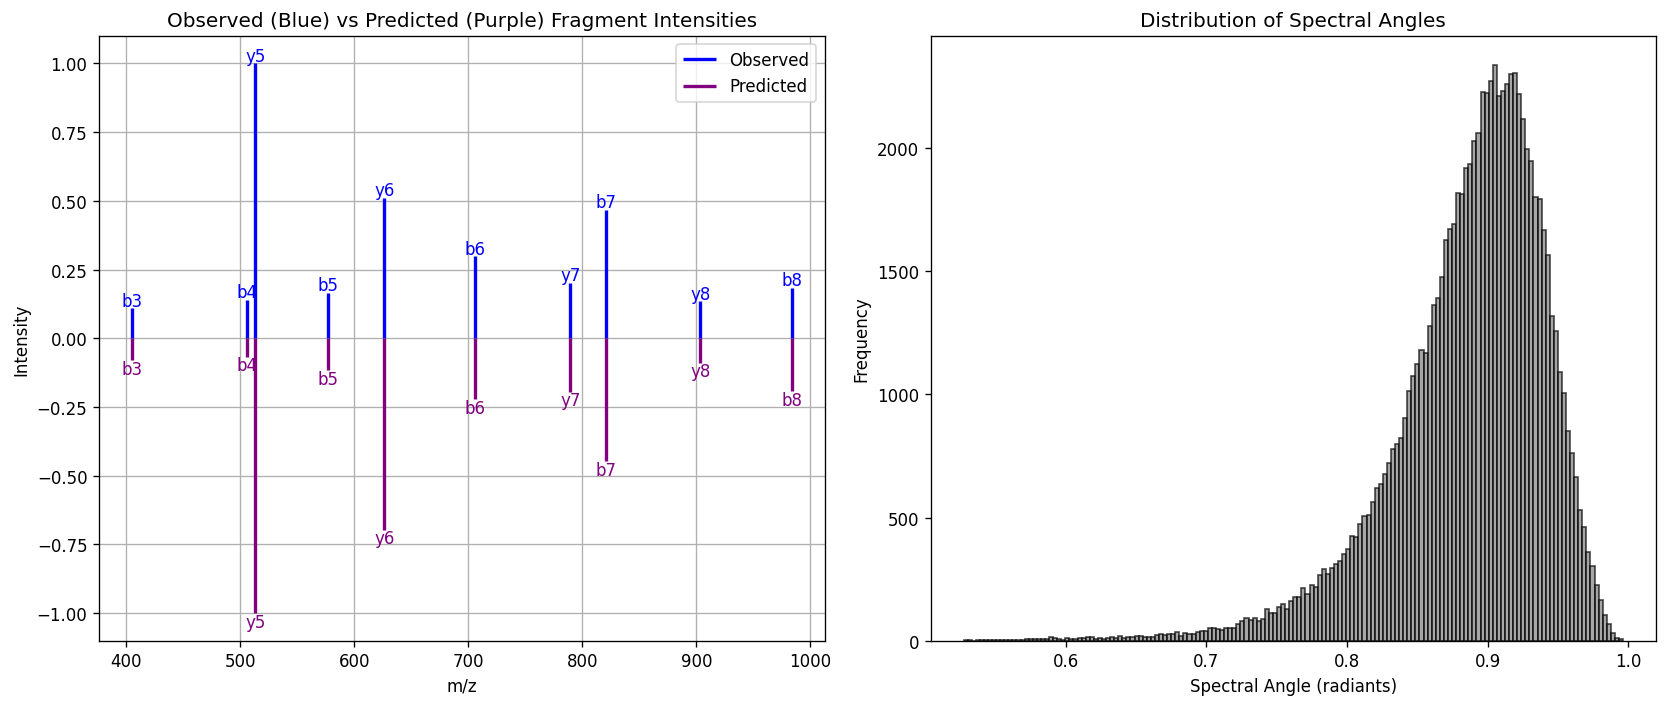

In [41]:
from matplotlib import pyplot as plt
from sagepy.core.scoring import IonType
from sagepy.rescore.utility import cosim_to_spectral_angle_sim

target_index = 150

# Sample spectral angles data (replace with actual data)
spectral_angles = [cosim_to_spectral_angle_sim(x.cosine_similarity) for x in psm_list]

# Create the figure with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)

norm_sum = np.max(psm_list[target_index].fragments_observed.intensities)
intensity_norm = psm_list[target_index].fragments_observed.intensities / norm_sum

# Mirror plot (Observed vs Predicted fragment intensities)
ax1.vlines(psm_list[target_index].fragments_observed.mz_calculated, 0, intensity_norm, color='blue', label='Observed', lw=2)
ax1.vlines(psm_list[target_index].fragments_predicted.mz_calculated, 0, [-i for i in psm_list[target_index].fragments_predicted.intensities], color='purple', label='Predicted', lw=2)

# Label peaks
for mz, intensity, ion_type, ordinal in zip(psm_list[target_index].fragments_observed.mz_calculated, intensity_norm, 
                                            psm_list[target_index].fragments_observed.ion_types, psm_list[target_index].fragments_observed.fragment_ordinals):
    ion_type = "b" if ion_type == IonType("B") else "y"
    ax1.text(mz, intensity + .01, f'{ion_type}{ordinal}', ha='center', color='blue')

for mz, intensity, ion_type, ordinal in zip(psm_list[target_index].fragments_predicted.mz_calculated, psm_list[target_index].fragments_predicted.intensities, 
                                            psm_list[target_index].fragments_predicted.ion_types, psm_list[target_index].fragments_predicted.fragment_ordinals):
    ion_type = "b" if ion_type == IonType("B") else "y"
    ax1.text(mz, -intensity - .05, f'{ion_type}{ordinal}', ha='center', color='purple')

ax1.set_xlabel("m/z")
ax1.set_ylabel("Intensity")
ax1.set_title("Observed (Blue) vs Predicted (Purple) Fragment Intensities")
ax1.legend()
ax1.grid(True)

ax2.hist(spectral_angles, bins="auto", color='gray', edgecolor='black', alpha=0.7)
ax2.set_title("Distribution of Spectral Angles")
ax2.set_xlabel("Spectral Angle (radiants)")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Serialize PSMs to disk
You can actually use any format you like, conveniently, sagepy has a binary json serializaton available that you can use if you want:

In [44]:
from sagepy.core.scoring import psms_to_json_bin

# creates an array of bytes
json_bin = psms_to_json_bin(psm_list)

with open("psms.bin", "wb") as outfile:
    outfile.write(bytearray(json_bin))
outfile.close()